# Group Classification (ZenML)

Train the group classifier with the updated pipeline structure.

In [1]:
from pathlib import Path
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import group_classification_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Parquet inputs. Edit this list to point at the files you want to train on.
data_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(data_dir.glob("ml_output_*.parquet"))

# Example: uncomment to select a smaller subset
parquet_paths = parquet_paths[:1]

parquet_paths = [str(p) for p in parquet_paths]
if not parquet_paths:
    raise RuntimeError(f"No parquet files found in {data_dir}")


In [3]:
# Run the pipeline
base_loader_config = {
    "mode": "train",
    # "batch_size": 64,  # Optional: force a fixed batch size instead of HPO-selected
    "chunk_row_groups": 4,
    "chunk_workers": 0,
    "train_fraction": 0.80,
    "val_fraction": 0.10,
    "test_fraction": 0.10,
    "split_seed": 0,
}

pipeline_config = {
    "loader": {
        # Loader step validates source files and stores source paths.
        "config_json": {"mode": "train"},
    },
    "hpo": {
        "enabled": True,
        "n_trials": 4,
        "max_epochs": 10,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 2,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": False, "mode": "reduce-overhead"},
        "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/group_classifier_hpo.db",
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": 0.125},
            "val": {"split": "val", "sample_fraction": 0.125},
        },
    },
    "train": {
        "max_epochs": 25,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 5,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": True, "mode": "reduce-overhead"},
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": None},
            "val": {"split": "val", "sample_fraction": None},
        },
    },
    "evaluate": {
        "threshold": 0.5,
        "loader_config": {
            "base": dict(base_loader_config),
            "evaluate": {"split": "test", "sample_fraction": None},
        },
    },
    "export": {
        "prefer_cuda": True,
        "export_dir": str(PROJECT_ROOT / "trained_models" / "groupclassifier"),
    },
}

run = group_classification_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    pipeline_config=pipeline_config,
)




Initiating a new run for the pipeline: group_classification_pipeline.
Caching is disabled by default for group_classification_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_group_classifier_dataset has started.
Step load_group_classifier_dataset has finished in 0.138s.
Step tune_group_classifier has started.


[I 2026-02-18 23:09:29,570] Using an existing study with name 'group_classifier_hpo' instead of creating a new one.


[tune_group_classifier] GPU available: True (cuda), used: True
[tune_group_classifier] TPU available: False, using: 0 TPU cores
[tune_group_classifier] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_classifier] You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set torch.set_float32_matmul_precision('medium' | 'high') which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[tune_group_classifier] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_group_classifier] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[tune_group_classifier] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[I 2026-02-18 23:09:36,234] Trial 228 finished with value: 0.029957728030589912 and parameters: {'batch_size_exp': 5, 'heads': 3, 'hidden': 219, 'num_blocks': 3, 'dropout': 0.0010502389058374675, 'lr': 0.00044220750122480517, 'weight_decay': 1.6216650503770226e-05}. Best is trial 218 with value: 0.028565383014770653.


[tune_group_classifier] GPU available: True (cuda), used: True
[tune_group_classifier] TPU available: False, using: 0 TPU cores
[tune_group_classifier] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_classifier] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.9 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:09:41,400] Trial 229 finished with value: 0.09038788825273514 and parameters: {'batch_size_exp': 5, 'heads': 3, 'hidden': 207, 'num_blocks': 3, 'dropout': 0.007875774384923019, 'lr': 0.00045028923011281247, 'weight_decay': 1.6140607315178752e-05}. Best is trial 218 with value: 0.028565383014770653.


[tune_group_classifier] GPU available: True (cuda), used: True
[tune_group_classifier] TPU available: False, using: 0 TPU cores
[tune_group_classifier] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_classifier] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:09:47,258] Trial 230 finished with value: 0.028262717506060235 and parameters: {'batch_size_exp': 5, 'heads': 3, 'hidden': 219, 'num_blocks': 3, 'dropout': 0.00013525814404249437, 'lr': 0.0003554095467510017, 'weight_decay': 1.7773919173599153e-05}. Best is trial 230 with value: 0.028262717506060235.


[tune_group_classifier] GPU available: True (cuda), used: True
[tune_group_classifier] TPU available: False, using: 0 TPU cores
[tune_group_classifier] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_classifier] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_group_classifier] Trainer.fit stopped: max_epochs=10 reached.


[I 2026-02-18 23:09:56,004] Trial 231 finished with value: 0.06112381529349547 and parameters: {'batch_size_exp': 5, 'heads': 3, 'hidden': 222, 'num_blocks': 3, 'dropout': 0.014792388384991303, 'lr': 0.0003533283524965952, 'weight_decay': 2.3533821921137585e-05}. Best is trial 230 with value: 0.028262717506060235.


Step tune_group_classifier has finished in 26.635s.
Step train_group_classifier has started.
[train_group_classifier] GPU available: True (cuda), used: True
[train_group_classifier] TPU available: False, using: 0 TPU cores
[train_group_classifier] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[train_group_classifier] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ OptimizedModule   │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 73                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[train_group_classifier] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_group_classifier] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[train_group_classifier] No materializer is registered for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_group_classifier has finished in 1m50s.
Step evaluate_group_classifier has started.
Step evaluate_group_classifier has finished in 1.923s.
Step export_group_classifier has started.
Step export_group_classifier has finished in 0.839s.
Pipeline run has finished in 2m24s.


metrics: {'loss': 0.09616236213425508, 'accuracy': 0.9871441721916199, 'exact_match': 0.9696969985961914, 'confusion': [{'tp': 0.9794520547945206, 'fp': 0.0, 'fn': 0.02054794520547945}, {'tp': 0.9387755102040817, 'fp': 0.006802721088435374, 'fn': 0.05442176870748299}, {'tp': 0.9759036144578314, 'fp': 0.024096385542168676, 'fn': 0.0}], 'threshold': 0.5, 'train_loss_history': [0.2439015551762441, 0.07325442610575822, 0.058170886471824314, 0.05037594496511867, 0.04028926237213904, 0.034981516092866705, 0.029902327877236005, 0.02762670926593535, 0.024795073193853247, 0.02371356034454983, 0.02266532575404671, 0.02185405493389259], 'train_loss_history_total_points': 12, 'val_loss_history': [0.7049440741539001, 0.05697134652232029, 0.03818515675826645, 0.033473374464606145, 0.04038127633381863, 0.030217714750264982, 0.03776168455939968, 0.028561185855342418, 0.03148979300214928, 0.028755193399217893, 0.028604861396383876, 0.02921540441100809, 0.02975238776024507], 'val_loss_history_total_poin

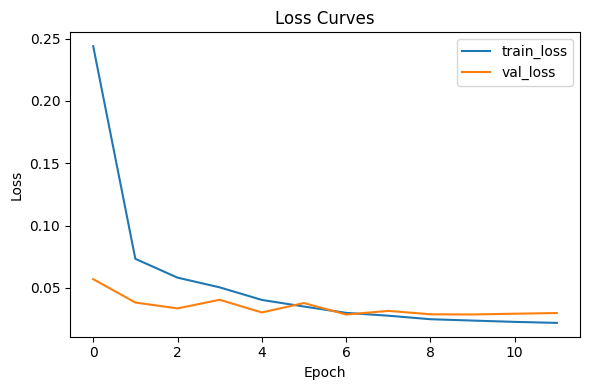

In [4]:
trained_module = load_step_output(run, "train_group_classifier")
metrics = load_step_output(run, "evaluate_group_classifier")
export = load_step_output(run, "export_group_classifier")

print("metrics:", metrics)
print("export:", export)

# Plot loss curves
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot

if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")

LossCurvesPlot().render(trained_module, show=True)
